# 1. Gradient descent and its modifications

In [183]:
from dataclasses import dataclass
from typing import Callable
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

Define global sympy symbols

In [8]:
sx, sy = sp.symbols('x y')

Define benchmark function structure

In [145]:
@dataclass
class Benchmark:
  name: str
  f: Callable[[float, float], float] # Formula
  gf: Callable[[float, float], np.array] # Gradient
  minimum: tuple # Global minimum point
  domain: tuple # Search domain per each component

  def __post_init__(self):
    pass

Pick two benchmark functions for tests: McCormick and Booth functions

In [146]:
mccormick = Benchmark(
  name='McCormick function',
  f=lambda x, y: np.sin(x + y) + (x - y) ** 2 - 1.5 * x + 2.5 * y + 1,
  gf=lambda x, y: np.array([
    np.cos(x + y) + 2 * (x - y) - 1.5,
    np.cos(x + y) - 2 * (x - y) + 2.5
  ]),
  minimum=(-0.54719, -1.54719),
  domain=((-1.5, 4), (-3, 4))
)

In [147]:
booth = Benchmark(
  name='Booth function',
  f=lambda x, y: (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2,
  gf=lambda x, y: np.array([
    2 * (x + 2 * y - 7) + 4 * (2 * x + y - 5),
    4 * (x + 2 * y - 7) + 2 * (2 * x + y - 5)
  ]),
  minimum=(1, 3),
  domain=((-10, 10), (-10, 10))
)

Classic gradient descent

In [206]:
def gradient_descent(
    gf: Callable[[float, float], np.array],
    start: tuple,
    lr: float = 0.01,
    max_iters: float=100,
    tol: float = 1e-6):
  p = np.array(start)
  history: list = [p]

  for _ in range(max_iters):
    pp = p - gf(p[0], p[1]) * lr
    history.append(pp)
    if np.linalg.norm(p - pp) < tol:
      break
    p = pp

  return p, history

Gradient descent with momentum

In [238]:
def gradient_descent_with_momentum(
    gf: Callable[[float, float], np.array],
    start: tuple,
    lr: float = 0.01,
    momentum=0.5,
    max_iters: float=100,
    tol: float = 1e-6):
  p = np.array(start)
  history: list = [p]
  velocity = 0

  for _ in range(max_iters):
    velocity = momentum * velocity - gf(p[0], p[1]) * lr
    pp = p + velocity
    history.append(pp)
    if np.linalg.norm(p - pp) < tol:
      break
    p = pp

  return p, history

Adaptive gradient descent

In [298]:
def adagrad(
    gf: Callable[[float, float], np.array],
    start: tuple,
    lr: float = 0.5,
    max_iters: float=1000,
    tol: float = 1e-6):
  p = np.array(start)
  history: list = [p]
  grad_sqr_acc = np.zeros_like(p)

  for _ in range(max_iters):
    g = gf(p[0], p[1])
    grad_sqr_acc += g ** 2
    nlr = lr / (np.sqrt(grad_sqr_acc) + 1e-8)
    pp = p - g * nlr
    history.append(pp)
    if np.linalg.norm(p - pp) < tol:
      break
    p = pp

  return p, history

Gradient descent with decaying learning rate

In [292]:
def decaying_gradient_descent(
    gf: Callable[[float, float], np.array],
    start: tuple,
    beta: float=0.1,
    initial_lr: float = 0.1,
    max_iters: float=100,
    tol: float = 1e-6):
  p = np.array(start)
  history: list = [p]
  lr = initial_lr

  for i in range(1, max_iters + 1):
    pp = p - gf(p[0], p[1]) * lr
    lr = initial_lr / (1 + beta * i)
    history.append(pp)
    if np.linalg.norm(p - pp) < tol:
      break
    p = pp

  return p, history

Visualization of benchmark function with every gradient descent modification

In [341]:
def visualize(bench: Benchmark):
  fig, axes = plt.subplots(4, 1, figsize=(30, 30), subplot_kw=dict(projection='3d'))
  fig.suptitle(bench.name)

  x = np.linspace(bench.domain[0][0], bench.domain[0][1], 100)
  y = np.linspace(bench.domain[1][0], bench.domain[1][1], 100)

  xz, yz = np.meshgrid(x, y)
  z = bench.f(xz, yz)

  minimum = (*bench.minimum, bench.f(*bench.minimum))

  start_xy = (np.random.choice(x), np.random.choice(y))
  start = (*start_xy, bench.f(*start_xy))

  def render(ax, gd, title):
    # Function surface
    ax.plot_surface(xz, yz, z, cmap='inferno', alpha=0.5)

    # Minimum point
    ax.scatter(*minimum, color='lime', ec='k', s=50, lw=1, label='Global minimum')
    ax.text(*minimum, '({:.3f}, {:.3f}, {:.3f})'.format(*minimum))

    # Starting point
    ax.scatter(*start, color='cyan', ec='k', s=50, lw=1, label='Starting point')

    # Solution point and path
    solution, history = gd(bench.gf, start_xy)
    ax.scatter(*solution, bench.f(*solution), color='red', ec='k', s=50, lw=1, label='Solution point')

    x, y = zip(*history)
    ax.plot(x, y, [bench.f(xi, yi) for xi, yi in zip(x, y)], '-o', label='Solution path')

    error = np.abs(bench.f(*solution) - bench.f(*bench.minimum))
    ax.text2D(0, 0.9, f'Погрешность найденного решения: {error}', transform=ax.transAxes)

    ax.set_title(title)
    ax.legend()

  for i, (gd, title) in enumerate([
      (gradient_descent, 'Gradient descent'),
      (gradient_descent_with_momentum, 'GD with momentum'),
      (adagrad, 'Adaptive gradient descent'),
      (decaying_gradient_descent, 'Gradient descent with decay')]):
    render(axes[i], gd, title)

  plt.show()

Visualize every benchmark function

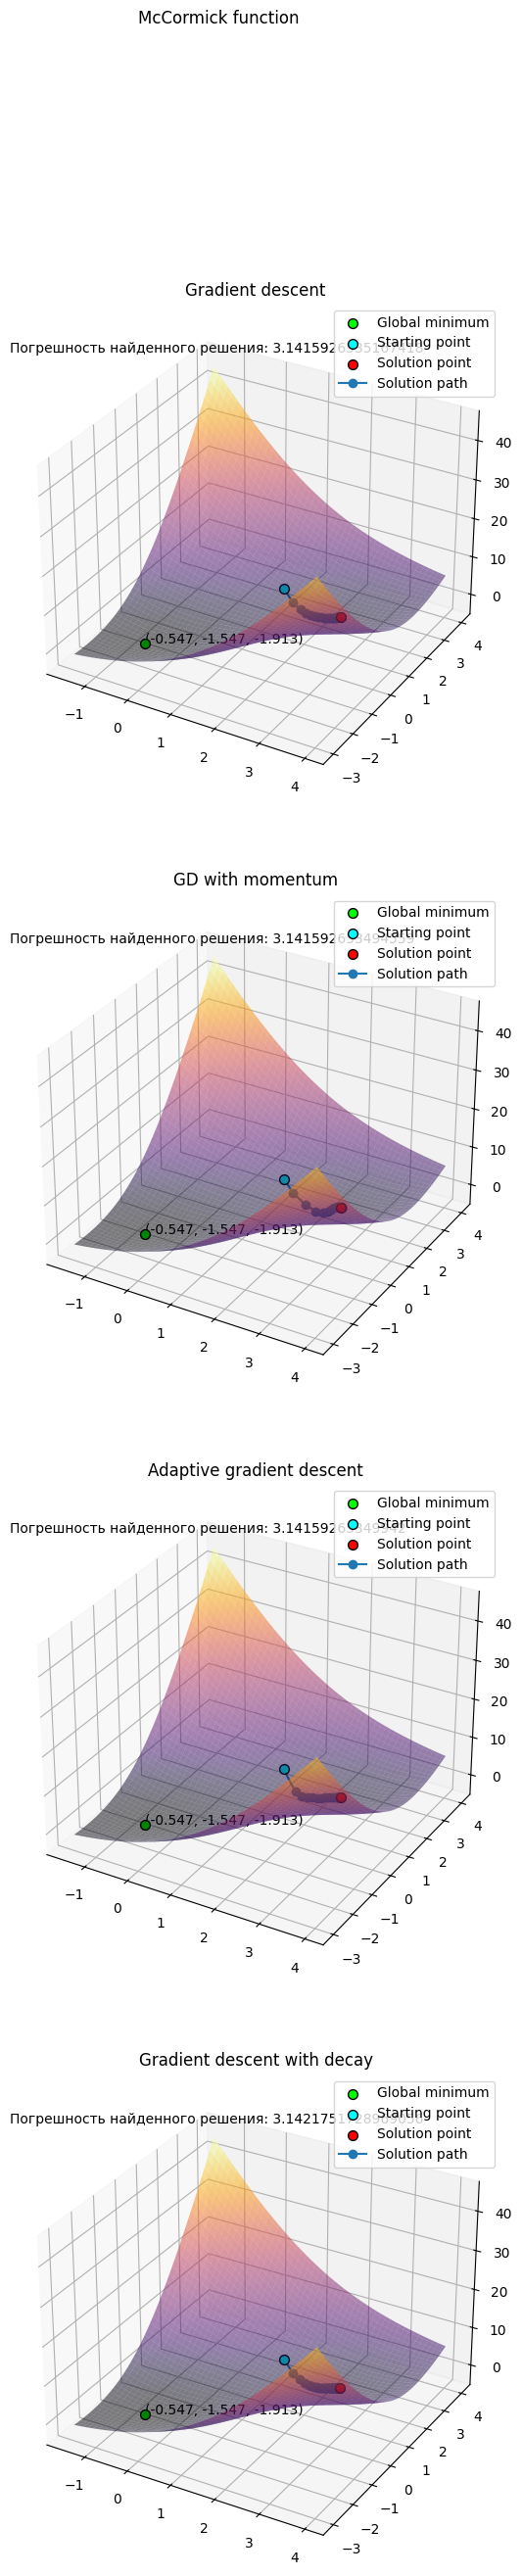

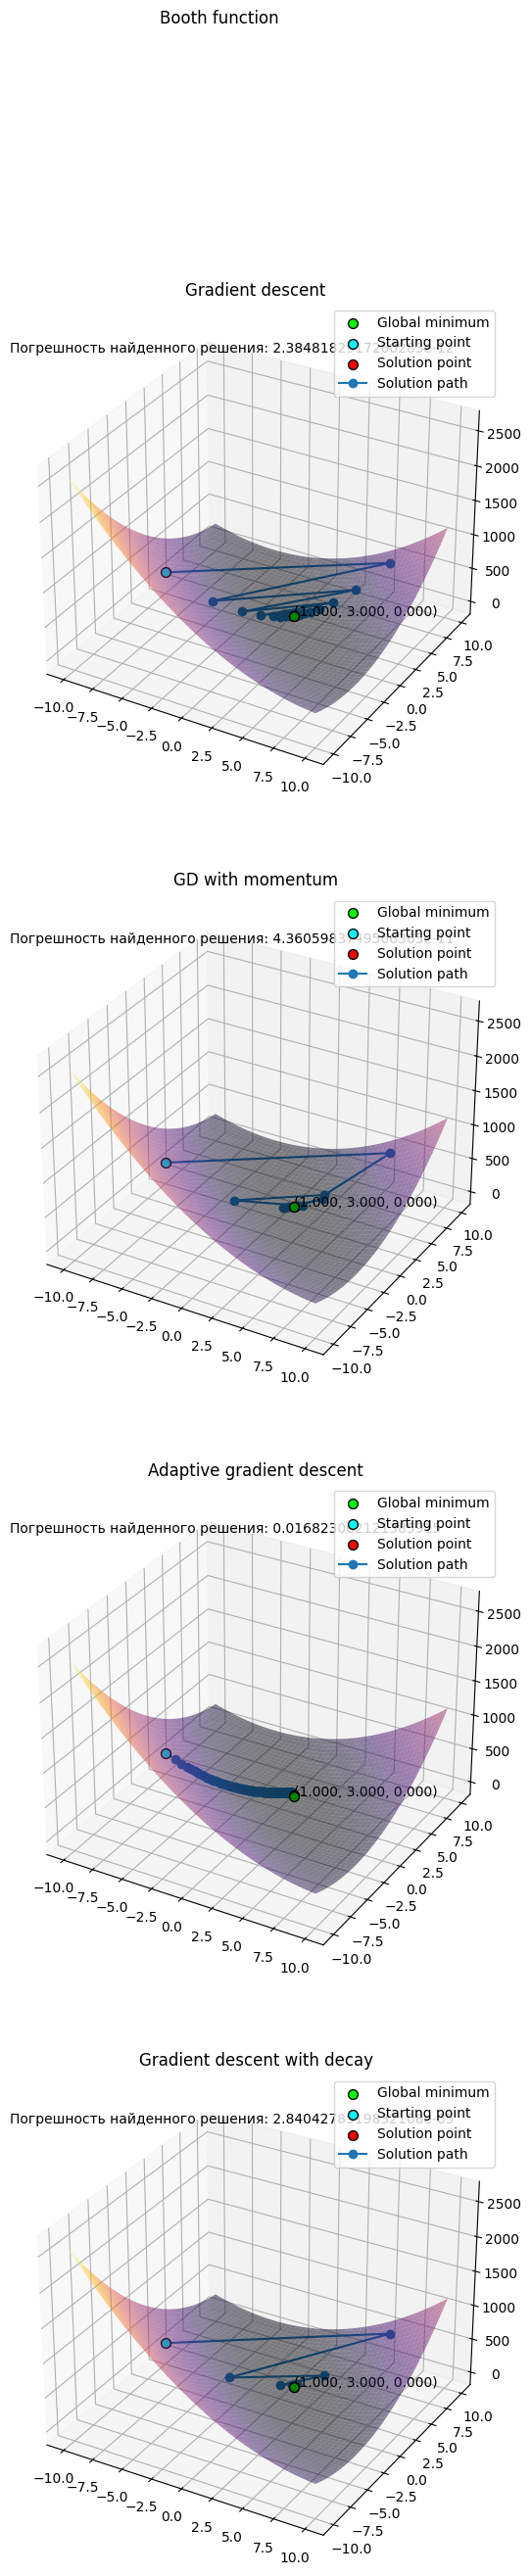

In [345]:
for bench in [mccormick, booth]:
  visualize(bench)